In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from types import SimpleNamespace
import os
from glob import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import xarray
import pandas as pd
from dataset.dataset import SamplesDataset
from dataset.normalization import ZeroMinMax
from dataset.station_dataset import GroundstationDataset
from lightning.pytorch import Trainer, LightningDataModule
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from models.model import ConvResNet
from models.lightningmodules import LitConvResNet
from torch.utils.data import DataLoader, 
from torchmetrics import MeanSquaredError
from tqdm import tqdm

plt.rcParams['text.usetex'] = False

In [4]:
## Set Up Model

# Emulator
chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/jup3gn3n/checkpoints/epoch=1-val_loss=0.00705.ckpt'

inference_fn = chkpt_fn.split('checkpoints')[0] + 'inference/'
if not os.path.exists(inference_fn):
    os.mkdir(inference_fn)

config = {
    "batch_size": 512,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS",],
    "x_features": ["dayofyear", "lat", "lon", 'SZA', "AZI",],# 'sat_SZA', 'sat_AZI', 'coscatter_angle'],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
    'binned':True,
    'max_epochs': 10,
    # Compute related
    'num_workers': 24,
    'ACCELERATOR': "gpu",
    'DEVICES': -1,
    'NUM_NODES': 1,
    'STRATEGY': "ddp",
    'PRECISION': "32",
    'EarlyStopping': {'patience':2},
    'ModelCheckpoint':{'every_n_epochs':1, 'save_top_k':1},
    'chkpt_fn': chkpt_fn,
}
config = SimpleNamespace(**config)

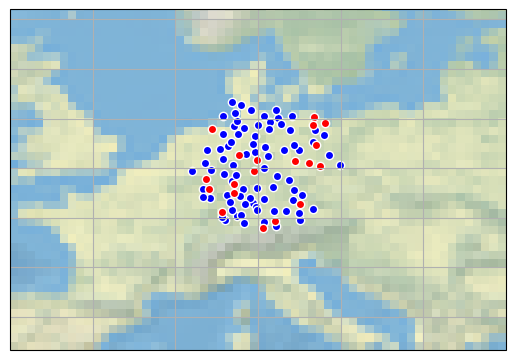

In [6]:
zarr_fns = glob('../../ZARR/DWD/DWD_SOLAR_*.zarr')
station_names = [int(os.path.basename(fn).split('SOLAR_')[-1].split('.')[0]) for fn in zarr_fns]
index = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_index.nc')
index = index.sel(station_id=station_names)


train_id = [15000, 2638, 662, 342, 691, 4104, 1684, 5426, 1766, 3167, 596, 880, 1346, 4271, 1550, 3196, 5792, 2485, 856, 1468, 3287, 4336, 701, 3126, 891, 1078, 4393, 963, 5705, 5546, 7368, 4887, 164, 704, 2261, 656, 2559, 6197, 3513, 3032, 7351, 430, 1443, 2907, 5856, 5404, 6163, 2483, 3268, 2601, 15444, 13674, 7374, 5480, 7367, 4745, 2014, 4625, 5100, 3761, 460, 7369, 3086, 3366, 282, 591, 1639, 232, 4177, 7370, 2667, 4928, 2712, 4466, 5397, 5516, 1975, 1503, 2115, 1605]
# Zugspitze = 5792
train_id.remove(5792)
valid_id = [1757, 5109, 953, 3028, 2290, 5906, 2171, 427, 2932, 2812, 5839, 1691, 3811, 1420, 5142, 4911, 3660, 3730, 1048]


index_train = index.sel(station_id=train_id)
index_valid = index.sel(station_id=valid_id)

a = index_train.plot.scatter(x='lon', y='lat', c='b', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
index_valid.plot.scatter(x='lon', y='lat', c='r', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
a.axes.gridlines()
a.axes.stock_img()
a.axes.set_extent([-5, 25, 40, 60])
plt.show()

In [7]:
valid_datasets = [GroundstationDataset(f'../../ZARR/DWD/DWD_SOLAR_{str(x).zfill(5)}.zarr', 
                                       config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                       config.transform, config.target_transform)
            for x in tqdm(valid_id)]
valid_dataset = torch.utils.data.ConcatDataset(valid_datasets)


100%|██████████| 19/19 [00:30<00:00,  1.59s/it]


In [9]:
train_datasets = [GroundstationDataset(f'../../ZARR/DWD/DWD_SOLAR_{str(x).zfill(5)}.zarr', 
                                       config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                       config.transform, config.target_transform,
                                      binned=config.binned)
            for x in tqdm(train_id)]
train_dataset = torch.utils.data.ConcatDataset(train_datasets)


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


In [10]:
zarr_fns = glob("../../ZARR/METEOSWISS/METEOSWISS_SOLAR_*.zarr")
station_names_meteoswiss = [
    os.path.basename(fn).split("SOLAR_")[-1].split(".")[0] for fn in zarr_fns
]
train_sample_meteoswiss = [
    "KOP",
    "HAI",
    "ELM",
    "JUN",
    "MAH",
    "BAS",
    "MRP",
    "CDF",
    "AND",
    "GLA",
    "EBK",
    "RUE",
    "PMA",
    "DIS",
    "CRM",
    "GOR",
    "VLS",
    "MOE",
    "SHA",
    "CHA",
    "SBE",
    "EIN",
    "GEN",
    "PIL",
    "GIH",
    "NAS",
    "BOL",
    "GVE",
    "BUS",
    "NEU",
    "ORO",
    "MTR",
    "VIS",
    "SBO",
    "PLF",
    "GRH",
    "UEB",
    "LEI",
    "ABO",
    "ARO",
    "SIM",
    "CGI",
    "MUB",
    "BRL",
    "WFJ",
    "MAG",
    "BER",
    "EVO",
    "LAT",
    "LUZ",
]

datasets_meteoswisss = [
    GroundstationDataset(
        f"../../ZARR/METEOSWISS/METEOSWISS_SOLAR_{str(x)}.zarr",
        config.y_vars,
        config.x_vars,
        config.x_features,
        config.patch_size["x"],
        config.transform,
        config.target_transform,
        binned=config.binned,
    )
    for x in tqdm(train_sample_meteoswiss)
]

train_dataset_meteoswiss = torch.utils.data.ConcatDataset(datasets_meteoswisss)
# train_dataset = torch.utils.data.ConcatDataset([train_dataset, train_dataset_meteoswiss])

100%|██████████| 50/50 [02:30<00:00,  3.01s/it]


In [11]:
zarr_fns = glob('../../ZARR/IEA_PVPS/IEA_PVPS_*.zarr')
station_names_bsrn = [os.path.basename(fn).split('IEA_PVPS_')[-1].split('.')[0] for fn in zarr_fns]
bsrn_datasets = [GroundstationDataset(f'../../ZARR/IEA_PVPS/IEA_PVPS_{x}.zarr', 
                                        config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                        config.transform, config.target_transform, sarah_idx_only=True)
                            for x in tqdm(station_names_bsrn)]
bsrn_dataset = torch.utils.data.ConcatDataset(bsrn_datasets)

100%|██████████| 14/14 [00:36<00:00,  2.59s/it]


In [21]:

class DataModule(LightningDataModule):

  def __init__(self, train_dataset, val_dataset,  bsrn_dataset, meteoswiss_dataset, batch_size = 2048):

    super(DataModule, self).__init__()
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.bsrn_dataset = bsrn_dataset
    self.meteoswiss_dataset = meteoswiss_dataset 
    self.batch_size = batch_size
    self.num_dataloaders=3
    
  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True, num_workers=config.num_workers)
  
  def val_dataloader(self):
    val_loader0 = DataLoader(self.val_dataset, batch_size = 4096, shuffle = False, num_workers=config.num_workers)
    val_loader1 = DataLoader(self.bsrn_dataset, batch_size = 4096, shuffle = False, num_workers=config.num_workers)
    val_loader2 = DataLoader(self.meteoswiss_dataset, batch_size = 4096, shuffle = False, num_workers=config.num_workers)
    return [val_loader0, val_loader1, val_loader2]

dm = DataModule(train_dataset, valid_dataset, bsrn_dataset, train_dataset_meteoswiss, config.batch_size)


In [14]:
# load checkpoint
estimator = LitConvResNet(
        learning_rate=1e-6,
        config=config,
        monitor_loss='val_loss/dataloader_idx_0',
    )

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.


# Groundstations only 

In [ ]:

wandb_logger = WandbLogger(name='Trained on DWD', project="SIS_point_estimation_groundstation")

mc_sarah = ModelCheckpoint(
        monitor='val_loss/dataloader_idx_1', 
        save_top_k = 3,
        save_last=True
        # filename='{epoch}-{val_loss:.5f}'
    ) 

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=2,
    accelerator='gpu',
    precision=config.PRECISION,
    callbacks=[mc_sarah],
    log_every_n_steps=50,
    num_sanity_val_steps=0,
    max_time="00:2:00:00",
    val_check_interval=0.1,
)


In [ ]:
trainer.fit(estimator, dm)

In [ ]:
wandb_logger.experiment.finish()

# Finetuning the Emulator

In [47]:
chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/jup3gn3n/checkpoints/epoch=1-val_loss=0.00705.ckpt'
config.chkpt_fn = chkpt_fn

estimator = LitConvResNet.load_from_checkpoint(config.chkpt_fn)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.


In [49]:
for par in estimator.model.mlp.parameters():
    par.requires_grad = False
    

estimator.set_reference_parameters([par.clone().detach() for par in estimator.model.parameters()])
estimator.parameter_loss = True
estimator.alpha = 5000

In [50]:
for name, par in estimator.model.mlp.named_parameters():
    print(name, par.shape, par.requires_grad)

0.weight torch.Size([256, 261]) False
0.bias torch.Size([256]) False
1.weight torch.Size([256]) False
1.bias torch.Size([256]) False
3.weight torch.Size([64, 256]) False
3.bias torch.Size([64]) False
4.weight torch.Size([64]) False
4.bias torch.Size([64]) False
6.weight torch.Size([1, 64]) False
6.bias torch.Size([1]) False


In [51]:
estimator.lr = 1e-6
estimator.configure_optimizers()

{'optimizer': AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 1e-07
     maximize: False
     weight_decay: 0.1
 ),
 'lr_scheduler': {'scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau at 0x155164abb160>,
  'monitor': 'val_loss',
  'interval': 'epoch',
  'frequency': 0.25}}

In [52]:

wandb_logger = WandbLogger(name='finetuned on dwd', project="SIS_point_estimation_groundstation")

wandb_logger.experiment.config.update(vars(config))

mc_sarah = ModelCheckpoint(
        monitor='val_loss/dataloader_idx_1', 
        save_top_k = 3,
        filename='{epoch}-bsrn{val_loss/dataloader_idx_1:.5f}-dwd{val_loss/dataloader_idx_0:.5f}-meteo{val_loss/dataloader_idx_2:.5f}',
        save_last=True,
    ) 

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=5,
    accelerator='gpu',
    precision=config.PRECISION,
    callbacks=[mc_sarah],
    log_every_n_steps=500,
    num_sanity_val_steps=0,
    max_time="00:3:00:00",
    val_check_interval=0.10,
    # check_val_every_n_epoch=4,
    
)



/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [53]:
trainer.validate(
    estimator, dm
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     MeanAbsoluteError     │     82.06161499023438     │     82.06161499023438     │     82.06161499023438     │
│        MeanMetric         │       553.791015625       │       553.791015625       │       553.791015625       │
│          R2Score          │    0.8368136286735535     │    0.8368136286735535     │    0.8368136286735535     │
│         val_loss          │    0.02546679601073265    │    0.02568252943456173    │    0.04100898280739784    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'val_loss/dataloader_idx_0': 0.02546679601073265,
  'MeanMetric': 553.791015625,
  'MeanAbsoluteError': 82.06161499023438,
  'R2Score': 0.8368136286735535},
 {'val_loss/dataloader_idx_1': 0.02568252943456173,
  'MeanMetric': 553.791015625,
  'MeanAbsoluteError': 82.06161499023438,
  'R2Score': 0.8368136286735535},
 {'val_loss/dataloader_idx_2': 0.04100898280739784,
  'MeanMetric': 553.791015625,
  'MeanAbsoluteError': 82.06161499023438,
  'R2Score': 0.8368136286735535}]

In [ ]:
# trainer.validate(estimator, val_dataloader)
trainer.fit(
    estimator, dm,
)

In [ ]:
trainer.validate(
    estimator, train_dataset_meteoswiss
)

In [ ]:
wandb_logger.experiment.finish()

# validate on test set SARAH3 2023

In [20]:
wandb_logger = WandbLogger(project='SIS_point_estimation')

In [30]:
valid_dataset = SamplesDataset(
    x_vars=config.x_vars,
    y_vars=config.y_vars,
    x_features=config.x_features,
    patch_size=config.patch_size,
    transform=config.transform,
    target_transform=config.target_transform,
    patches_per_image=2048,
    validation='test',
)

In [31]:
valid_loader = DataLoader(valid_dataset, batch_size = None, shuffle = False, num_workers=24)

In [32]:
estimator = LitEstimatorPoint.load_from_checkpoint('/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/jup3gn3n/checkpoints/epoch=1-val_loss=0.00705.ckpt')

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.


In [26]:
trainer = Trainer(
    # logger=wandb_logger,
    max_epochs=20,
    accelerator='gpu',
    precision=config.PRECISION,
    log_every_n_steps=500,
    num_sanity_val_steps=0,
    max_time="00:3:00:00",
    # check_val_every_n_epoch=4,
)


/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.validate(estimator, valid_loader)

In [34]:


y = torch.cat(estimator.y[0])
y_hat = torch.cat(estimator.y_hat[0])
x_attr = torch.cat(estimator.x_attr[0])

y_hat = estimator.transform.inverse(y_hat.cpu(), estimator.y_vars)
y = estimator.transform.inverse(y.cpu(), estimator.y_vars)
x_attr = estimator.transform.inverse(x_attr.cpu(), estimator.x_features)

torch.save(y, './validation_results/y.pt')
torch.save(y_hat, './validation_results/y_hat.pt')
torch.save(x_attr, './validation_results/x_attr.pt')


In [42]:
torch.sqrt(torch.nanmean((y-y_hat)**2))

tensor(49.1474)